# annunity investment strategy vs SPY500

In [1]:
# load data anslysis packages
import pandas as pd
import numpy as np
# import visulation tools
import matplotlib.pyplot as plt
import seaborn as sns

# display max column numbers
pd.options.display.max_columns = None


## scenario 1: 4% return rate


Running simulation with user's parameters:
Base Balance: $100,000
Bonus: $0
Total Initial Balance: $100,000
Annual Returns: 4.0%, 6.0%, 7.000000000000001%, 8.0%
Withdrawal Start Year: 2041
Withdrawal End Year: 2072
Number of years in simulation: 48


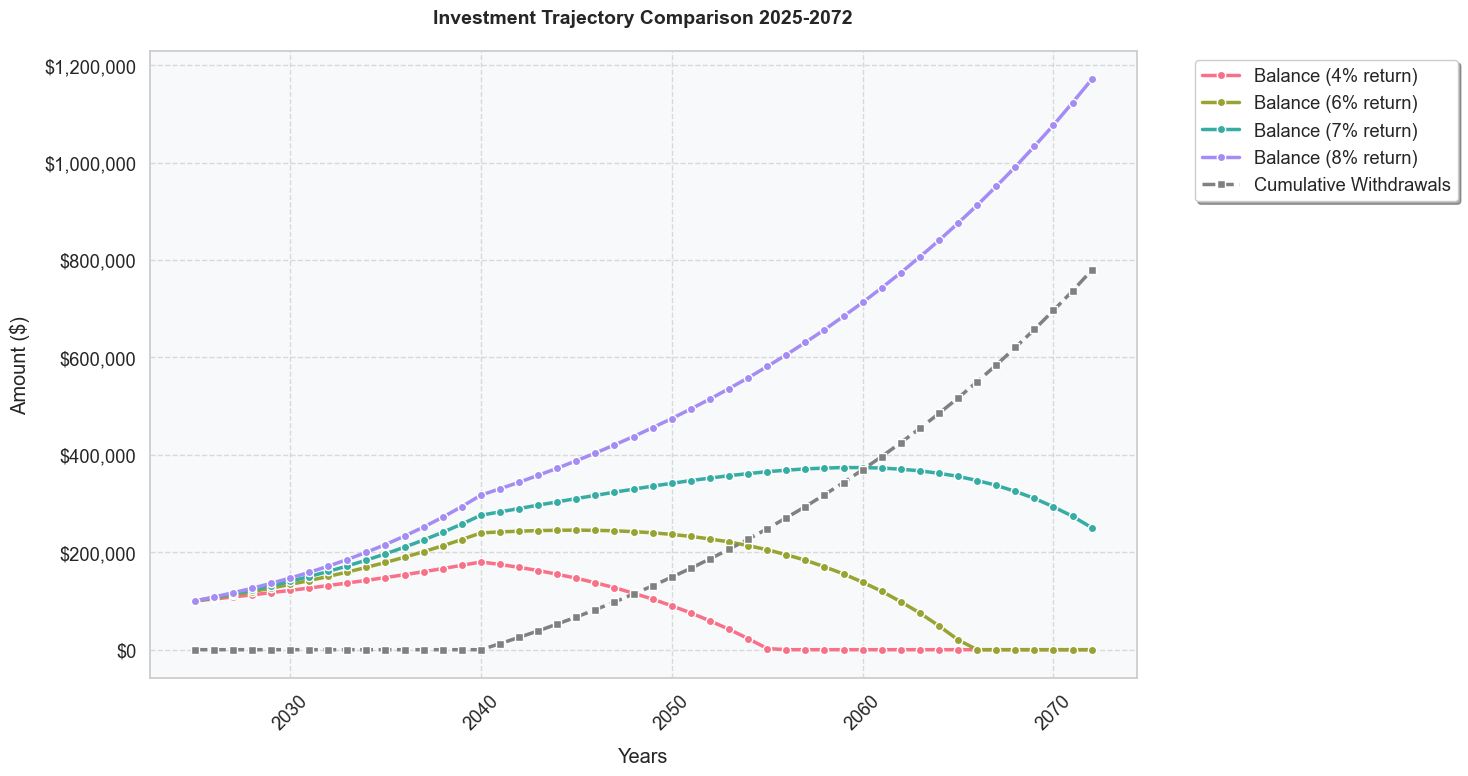


Key Statistics:

Return Rate: 4%
Final Balance: $0.00
Total Withdrawn: $778,872.00
Balance hits zero in: 2056
Total withdrawals after balance hits zero: $508,132.00

Return Rate: 6%
Final Balance: $0.00
Total Withdrawn: $778,872.00
Balance hits zero in: 2066
Total withdrawals after balance hits zero: $228,788.00

Return Rate: 7%
Final Balance: $250,579.35
Total Withdrawn: $778,872.00

Return Rate: 8%
Final Balance: $1,170,526.56
Total Withdrawn: $778,872.00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, List, Dict, Callable

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

def calculate_investment_trajectory(
    initial_balance: float,
    annual_return: float,
    withdrawal_schedule: Union[float, List[float], Callable[[int, float], float]],
    withdrawal_start_year: int,
    max_years: int = 50,
    start_year: int = None
) -> dict:
    """
    Calculate investment balance and withdrawals over time.
    Balance can reach zero, but withdrawals continue as scheduled.
    
    Parameters:
    -----------
    initial_balance : float
        Starting amount in the investment account
    annual_return : float
        Annual return rate as a decimal (e.g., 0.10 for 10%)
    withdrawal_schedule : float or List[float] or Callable
        Can be one of:
        - float: Fixed annual withdrawal amount
        - List[float]: List of withdrawal amounts for each year
        - Callable: Function that takes (year, current_balance) and returns withdrawal amount
    withdrawal_start_year : int
        Year to start withdrawals (can be calendar year or relative year)
    max_years : int, optional
        Number of years to simulate (default 50)
    start_year : int, optional
        Calendar year to start from (if None, uses relative years)
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'balances': array of account balances for each year
        - 'withdrawals': array of withdrawals for each year
        - 'cumulative_withdrawals': array of cumulative withdrawals for each year
        - 'years': array of years (calendar years if start_year provided, else relative years)
    """
    # Initialize arrays to store results
    balances = np.zeros(max_years)
    withdrawals = np.zeros(max_years)
    cumulative_withdrawals = np.zeros(max_years)
    
    # Create years array (either calendar or relative years)
    if start_year is not None:
        years = np.arange(start_year, start_year + max_years)
        withdrawal_start_year_relative = withdrawal_start_year - start_year
    else:
        years = np.arange(max_years)
        withdrawal_start_year_relative = withdrawal_start_year
    
    # Set initial balance
    balances[0] = initial_balance
    
    # Convert fixed withdrawal amount to a function
    if isinstance(withdrawal_schedule, (int, float)):
        fixed_amount = float(withdrawal_schedule)
        withdrawal_schedule = lambda year, balance: fixed_amount
    # Convert list of withdrawals to a function
    elif isinstance(withdrawal_schedule, list):
        withdrawal_list = withdrawal_schedule
        withdrawal_schedule = lambda year, balance: withdrawal_list[min(year - withdrawal_start_year_relative, len(withdrawal_list)-1)] if year >= withdrawal_start_year_relative else 0
    
    # Simulate account growth and withdrawals over time
    for year_idx in range(1, max_years):
        # Apply growth to previous year's balance (only if balance is positive)
        if balances[year_idx-1] > 0:
            balances[year_idx] = balances[year_idx-1] * (1 + annual_return)
        
        # Apply withdrawal if we've reached the withdrawal start year
        if year_idx >= withdrawal_start_year_relative:
            # Calculate withdrawal amount based on the schedule
            withdrawal = withdrawal_schedule(year_idx, balances[year_idx])
            
            # Record the withdrawal
            withdrawals[year_idx] = withdrawal
            cumulative_withdrawals[year_idx] = cumulative_withdrawals[year_idx-1] + withdrawal
            
            # Update balance (can go to zero but not negative)
            balances[year_idx] = max(0, balances[year_idx] - withdrawal)
        else:
            cumulative_withdrawals[year_idx] = cumulative_withdrawals[year_idx-1]
            
    return {
        'balances': balances,
        'withdrawals': withdrawals,
        'cumulative_withdrawals': cumulative_withdrawals,
        'years': years
    }

def plot_investment_trajectory(results_dict: dict, title: str = "Investment Trajectory Over Time"):
    """
    Plot the investment balance for multiple return rates and cumulative withdrawals over time.
    Uses seaborn for enhanced aesthetics.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary containing results for each return rate
    title : str
        Title for the plot
    """
    plt.figure(figsize=(15, 8))
    
    # Create custom color palette for balance lines
    n_returns = len(results_dict)
    balance_colors = sns.color_palette("husl", n_returns)
    
    # Plot balance for each return rate
    for (return_rate, results), color in zip(results_dict.items(), balance_colors):
        sns.lineplot(x=results['years'], y=results['balances'],
                    label=f'Balance ({return_rate}% return)',
                    linewidth=2.5, marker='o', markersize=6,
                    color=color, markeredgecolor='white',
                    markeredgewidth=1)
    
    # Plot cumulative withdrawals (same for all scenarios)
    sns.lineplot(x=results_dict[list(results_dict.keys())[0]]['years'],
                y=results_dict[list(results_dict.keys())[0]]['cumulative_withdrawals'],
                label='Cumulative Withdrawals',
                linewidth=2.5, marker='s', markersize=6,
                color='gray', linestyle='--',
                markeredgecolor='white',
                markeredgewidth=1)
    
    # Customize the plot
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Years', labelpad=10)
    plt.ylabel('Amount ($)', labelpad=10)
    
    # Format y-axis with dollar amounts
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              frameon=True, fancybox=True, shadow=True)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add background color
    plt.gca().set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # User's specific example
    base_balance = 100000
    bonus = 0
    initial_balance = base_balance + bonus
    annual_returns = [0.04, 0.06, 0.07, 0.08]  # 4% to 8%
    year_start = 2025
    withdrawal_start_year = 2041
    withdrawal_end_year = 2072
    
    withdrawal_schedule = [
        12282, 13024, 13284, 14087, 14368, 15236, 15541, 16479, 16809, 17824, 18181,
        19278, 19664, 20852, 21269, 22562, 23013, 24412, 24900, 26414, 26943, 28581,
        29152, 30925, 31543, 33461, 34130, 36206, 36930, 39175, 39959, 42388
    ]
    
    # Calculate max years needed
    max_years = withdrawal_end_year - year_start + 1
    
    print("\nRunning simulation with user's parameters:")
    print(f"Base Balance: ${base_balance:,}")
    print(f"Bonus: ${bonus:,}")
    print(f"Total Initial Balance: ${initial_balance:,}")
    print(f"Annual Returns: {', '.join(f'{r*100}%' for r in annual_returns)}")
    print(f"Withdrawal Start Year: {withdrawal_start_year}")
    print(f"Withdrawal End Year: {withdrawal_end_year}")
    print(f"Number of years in simulation: {max_years}")
    
    # Calculate trajectories for each return rate
    results_dict = {}
    for annual_return in annual_returns:
        results = calculate_investment_trajectory(
            initial_balance=initial_balance,
            annual_return=annual_return,
            withdrawal_schedule=withdrawal_schedule,
            withdrawal_start_year=withdrawal_start_year,
            max_years=max_years,
            start_year=year_start
        )
        results_dict[f"{annual_return*100:.0f}"] = results
    
    # Plot all scenarios
    plot_investment_trajectory(
        results_dict,
        title=f"Investment Trajectory Comparison {year_start}-{withdrawal_end_year}"
    )
    
    # Print key statistics for each return rate
    print(f"\nKey Statistics:")
    for return_rate, results in results_dict.items():
        final_balance = results['balances'][-1]
        total_withdrawn = results['cumulative_withdrawals'][-1]
        print(f"\nReturn Rate: {return_rate}%")
        print(f"Final Balance: ${final_balance:,.2f}")
        print(f"Total Withdrawn: ${total_withdrawn:,.2f}")
        
        # Find when balance hits zero (if it does)
        zero_balance_years = results['years'][results['balances'] == 0]
        if len(zero_balance_years) > 0:
            first_zero_year = zero_balance_years[0]
            print(f"Balance hits zero in: {first_zero_year}")
            remaining_withdrawals = total_withdrawn - results['cumulative_withdrawals'][results['years'] == first_zero_year][0]
            print(f"Total withdrawals after balance hits zero: ${remaining_withdrawals:,.2f}") 

## senerio 2: dynamnic withdrawal


In [4]:
withdrawal_schedule_2 = [
    17995, 22986, 23600, 23682, 24757, 28307, 28307, 28889, 30709,
    34912, 36958, 49029, 50199, 50322, 52666, 58835, 58835, 60937,
    64845, 71392, 75758, 92809, 95681, 96212, 100693, 112488, 112488,
    116508, 123979, 136497, 144844
]
annual_return_rates = [
    0.00, 3.57, 6.27, 9.39, 6.02, 22.95, 2.91, 0.46, 4.70, 12.54,
    0.00, 2.79, 6.42, 11.41, 6.07, 25.71, 2.46, 0.32, 4.12, 12.87,
    0.00, 1.79, 5.36, 11.30, 4.62, 23.92, 1.51, 0.10, 4.66, 11.71,
    0.00, 3.57, 6.41, 10.10, 6.12, 22.51, 3.09, 0.56, 4.66, 11.71,
    0.00, 3.57, 6.41, 10.10, 6.12, 22.51
]



Running simulation with user's parameters:
Base Balance: $100,000
Bonus: $0
Total Initial Balance: $100,000
Withdrawal Start Year: 2041
Withdrawal End Year: 2071
Number of years in simulation: 47


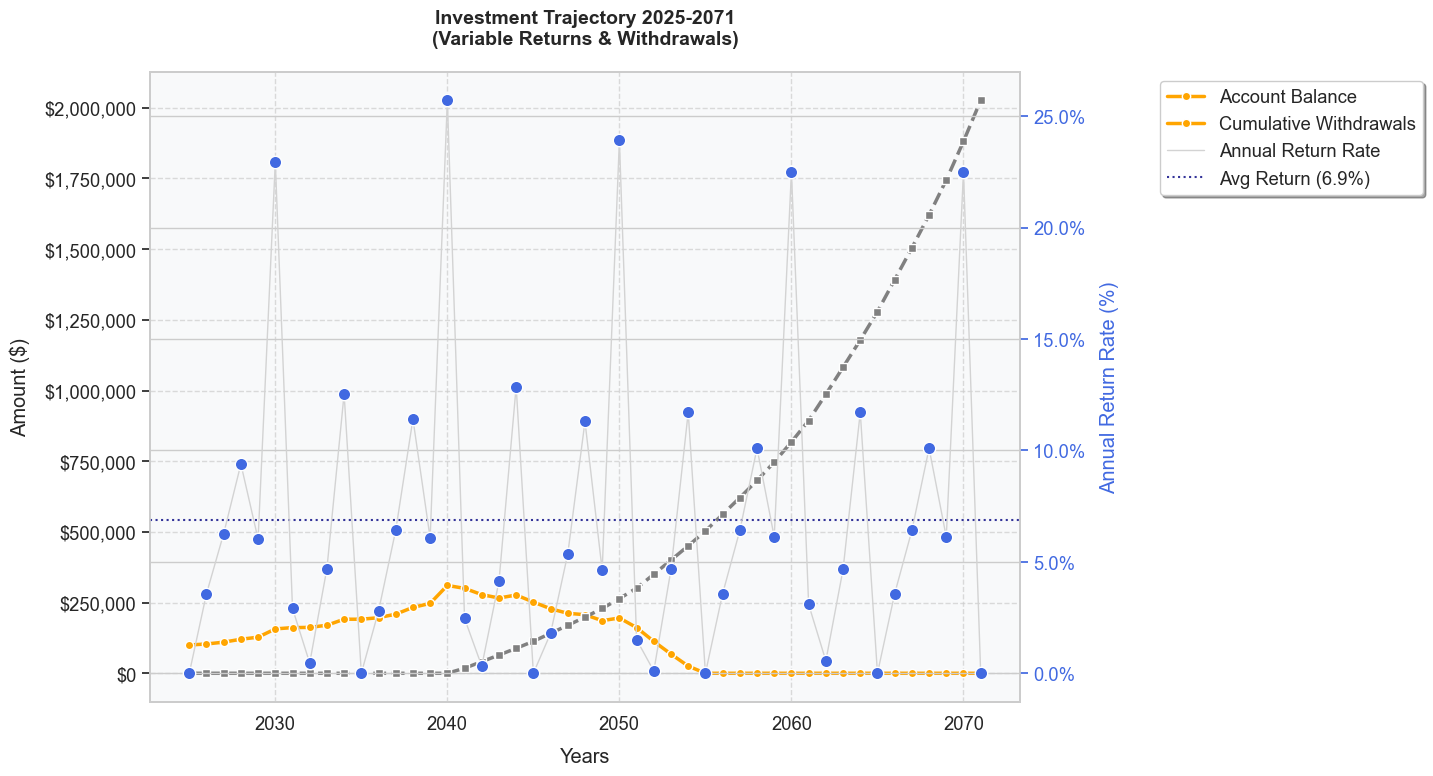


Key Statistics:
Final Balance: $0.00
Total Withdrawn: $2,026,119.00
Average Return Rate: 6.88%
Balance hits zero in: 2055
Total withdrawals after balance hits zero: $1,522,801.00


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, List, Dict, Callable

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

def calculate_investment_trajectory(
    initial_balance: float,
    annual_returns: Union[float, List[float]],
    withdrawal_schedule: Union[float, List[float], Callable[[int, float], float]],
    withdrawal_start_year: int,
    max_years: int = 50,
    start_year: int = None
) -> dict:
    """
    Calculate investment balance and withdrawals over time.
    Balance can reach zero, but withdrawals continue as scheduled.
    
    Parameters:
    -----------
    initial_balance : float
        Starting amount in the investment account
    annual_returns : float or List[float]
        Annual return rates as decimal (e.g., 0.10 for 10%)
        Can be single float or list of returns for each year
    withdrawal_schedule : float or List[float] or Callable
        Can be one of:
        - float: Fixed annual withdrawal amount
        - List[float]: List of withdrawal amounts for each year
        - Callable: Function that takes (year, current_balance) and returns withdrawal amount
    withdrawal_start_year : int
        Year to start withdrawals (can be calendar year or relative year)
    max_years : int, optional
        Number of years to simulate (default 50)
    start_year : int, optional
        Calendar year to start from (if None, uses relative years)
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'balances': array of account balances for each year
        - 'withdrawals': array of withdrawals for each year
        - 'cumulative_withdrawals': array of cumulative withdrawals for each year
        - 'years': array of years (calendar years if start_year provided, else relative years)
        - 'returns': array of return rates used for each year
    """
    # Initialize arrays to store results
    balances = np.zeros(max_years)
    withdrawals = np.zeros(max_years)
    cumulative_withdrawals = np.zeros(max_years)
    returns = np.zeros(max_years)
    
    # Create years array (either calendar or relative years)
    if start_year is not None:
        years = np.arange(start_year, start_year + max_years)
        withdrawal_start_year_relative = withdrawal_start_year - start_year
    else:
        years = np.arange(max_years)
        withdrawal_start_year_relative = withdrawal_start_year
    
    # Set initial balance
    balances[0] = initial_balance
    
    # Convert single return rate to list if needed
    if isinstance(annual_returns, (int, float)):
        returns[:] = annual_returns
    else:
        # Repeat the return rates pattern if list is shorter than max_years
        returns = np.array([annual_returns[i % len(annual_returns)] for i in range(max_years)])
    
    # Convert fixed withdrawal amount to a function
    if isinstance(withdrawal_schedule, (int, float)):
        fixed_amount = float(withdrawal_schedule)
        withdrawal_schedule = lambda year, balance: fixed_amount
    # Convert list of withdrawals to a function
    elif isinstance(withdrawal_schedule, list):
        withdrawal_list = withdrawal_schedule
        withdrawal_schedule = lambda year, balance: withdrawal_list[min(year - withdrawal_start_year_relative, len(withdrawal_list)-1)] if year >= withdrawal_start_year_relative else 0
    
    # Simulate account growth and withdrawals over time
    for year_idx in range(1, max_years):
        # Apply growth to previous year's balance (only if balance is positive)
        if balances[year_idx-1] > 0:
            balances[year_idx] = balances[year_idx-1] * (1 + returns[year_idx])
        
        # Apply withdrawal if we've reached the withdrawal start year
        if year_idx >= withdrawal_start_year_relative:
            # Calculate withdrawal amount based on the schedule
            withdrawal = withdrawal_schedule(year_idx, balances[year_idx])
            
            # Record the withdrawal
            withdrawals[year_idx] = withdrawal
            cumulative_withdrawals[year_idx] = cumulative_withdrawals[year_idx-1] + withdrawal
            
            # Update balance (can go to zero but not negative)
            balances[year_idx] = max(0, balances[year_idx] - withdrawal)
        else:
            cumulative_withdrawals[year_idx] = cumulative_withdrawals[year_idx-1]
            
    return {
        'balances': balances,
        'withdrawals': withdrawals,
        'cumulative_withdrawals': cumulative_withdrawals,
        'years': years,
        'returns': returns
    }

def plot_investment_trajectory(results: dict, title: str = "Investment Trajectory Over Time"):
    """
    Plot the investment balance and cumulative withdrawals over time.
    Uses seaborn for enhanced aesthetics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing results for a single scenario
    title : str
        Title for the plot
    """
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Plot balance and withdrawals on primary axis
    line1 = sns.lineplot(x=results['years'], y=results['balances'],
                label='Account Balance',
                linewidth=2.5, marker='o', markersize=6,
                color='orange',
                markeredgecolor='white',
                markeredgewidth=1,
                ax=ax1)
    
    line2 = sns.lineplot(x=results['years'], y=results['cumulative_withdrawals'],
                label='Cumulative Withdrawals',
                linewidth=2.5, marker='s', markersize=6,
                color='gray', linestyle='--',
                markeredgecolor='white',
                markeredgewidth=1,
                ax=ax1)
    
    # Create secondary axis for return rates
    ax2 = ax1.twinx()
    
    # Plot light grey connecting lines for returns
    line3 = ax2.plot(results['years'], results['returns'] * 100,
                     color='lightgray', linewidth=1, zorder=4,
                     label='Annual Return Rate')[0]
    
    # Plot return rate points on top of the lines
    scatter = ax2.scatter(results['years'], results['returns'] * 100,  # Convert to percentage
               label='_nolegend_',  # Don't show points in legend
               s=80,  # Point size
               color='royalblue',
               edgecolor='white',
               linewidth=1,
               zorder=5)  # Ensure points are drawn on top
    
    # Calculate and plot average return line
    avg_return = np.mean(results['returns']) * 100
    avg_line = ax2.axhline(y=avg_return, color='navy', linestyle=':',
                label=f'Avg Return ({avg_return:.1f}%)', alpha=0.8)
    
    # Customize primary axis (left - dollar amounts)
    ax1.set_xlabel('Years', labelpad=10)
    ax1.set_ylabel('Amount ($)', labelpad=10)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Customize secondary axis (right - percentages)
    ax2.set_ylabel('Annual Return Rate (%)', labelpad=10, color='royalblue')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
    ax2.tick_params(axis='y', colors='royalblue')
    
    # Set title
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    
    # Create combined legend
    all_lines = [line1.lines[0], line2.lines[0], line3, avg_line]
    all_labels = ['Account Balance', 'Cumulative Withdrawals', 
                 'Annual Return Rate', f'Avg Return ({avg_return:.1f}%)']
    ax1.legend(all_lines, all_labels,
              bbox_to_anchor=(1.15, 1), loc='upper left',
              frameon=True, fancybox=True, shadow=True)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add background color
    ax1.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # User's specific example with variable returns and withdrawals
    base_balance = 100000
    bonus = 0
    initial_balance = base_balance + bonus
    
    # Annual returns as percentages
    annual_return_rates = [
        0.00, 0.0357, 0.0627, 0.0939, 0.0602, 0.2295, 0.0291, 0.0046, 0.0470, 0.1254,
        0.00, 0.0279, 0.0642, 0.1141, 0.0607, 0.2571, 0.0246, 0.0032, 0.0412, 0.1287,
        0.00, 0.0179, 0.0536, 0.1130, 0.0462, 0.2392, 0.0151, 0.0010, 0.0466, 0.1171,
        0.00, 0.0357, 0.0641, 0.1010, 0.0612, 0.2251, 0.0309, 0.0056, 0.0466, 0.1171,
        0.00, 0.0357, 0.0641, 0.1010, 0.0612, 0.2251
    ]
    
    # Withdrawal schedule
    withdrawal_schedule = [
        17995, 22986, 23600, 23682, 24757, 28307, 28307, 28889, 30709,
        34912, 36958, 49029, 50199, 50322, 52666, 58835, 58835, 60937,
        64845, 71392, 75758, 92809, 95681, 96212, 100693, 112488, 112488,
        116508, 123979, 136497, 144844
    ]
    
    year_start = 2025
    withdrawal_start_year = 2041
    withdrawal_end_year = 2071
    
    # Calculate max years needed
    max_years = withdrawal_end_year - year_start + 1
    
    print("\nRunning simulation with user's parameters:")
    print(f"Base Balance: ${base_balance:,}")
    print(f"Bonus: ${bonus:,}")
    print(f"Total Initial Balance: ${initial_balance:,}")
    print(f"Withdrawal Start Year: {withdrawal_start_year}")
    print(f"Withdrawal End Year: {withdrawal_end_year}")
    print(f"Number of years in simulation: {max_years}")
    
    # Calculate trajectory
    results = calculate_investment_trajectory(
        initial_balance=initial_balance,
        annual_returns=annual_return_rates,
        withdrawal_schedule=withdrawal_schedule,
        withdrawal_start_year=withdrawal_start_year,
        max_years=max_years,
        start_year=year_start
    )
    
    # Plot scenario
    plot_investment_trajectory(
        results,
        title=f"Investment Trajectory {year_start}-{withdrawal_end_year}\n(Variable Returns & Withdrawals)"
    )
    
    # Print key statistics
    final_balance = results['balances'][-1]
    total_withdrawn = results['cumulative_withdrawals'][-1]
    avg_return = np.mean(results['returns']) * 100
    
    print(f"\nKey Statistics:")
    print(f"Final Balance: ${final_balance:,.2f}")
    print(f"Total Withdrawn: ${total_withdrawn:,.2f}")
    print(f"Average Return Rate: {avg_return:.2f}%")
    
    # Find when balance hits zero (if it does)
    zero_balance_years = results['years'][results['balances'] == 0]
    if len(zero_balance_years) > 0:
        first_zero_year = zero_balance_years[0]
        print(f"Balance hits zero in: {first_zero_year}")
        remaining_withdrawals = total_withdrawn - results['cumulative_withdrawals'][results['years'] == first_zero_year][0]
        print(f"Total withdrawals after balance hits zero: ${remaining_withdrawals:,.2f}") 

In [10]:
#%pip install yfinance

In [6]:
import pandas as pd
import yfinance as yf

# Download S&P 500 total return data from 1927 onward (using ^GSPC as proxy for index level)
# Note: Total returns including dividends are not directly available from Yahoo Finance;
# We'll download price data and mention the limitation

# Fetch historical data
spy = yf.download('^GSPC', start='1928-01-01', end='2025-01-01', interval='1mo', progress=False)

spy.head()


YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1985-01-01,179.630005,180.270004,163.360001,167.199997,2673710000
1985-02-01,181.179993,183.949997,177.750000,179.630005,2194620000
1985-03-01,180.660004,183.889999,176.529999,181.179993,2153090000
1985-04-01,179.830002,183.610001,177.860001,180.660004,1981880000
1985-05-01,189.550003,189.979996,178.350006,179.830002,2350340000


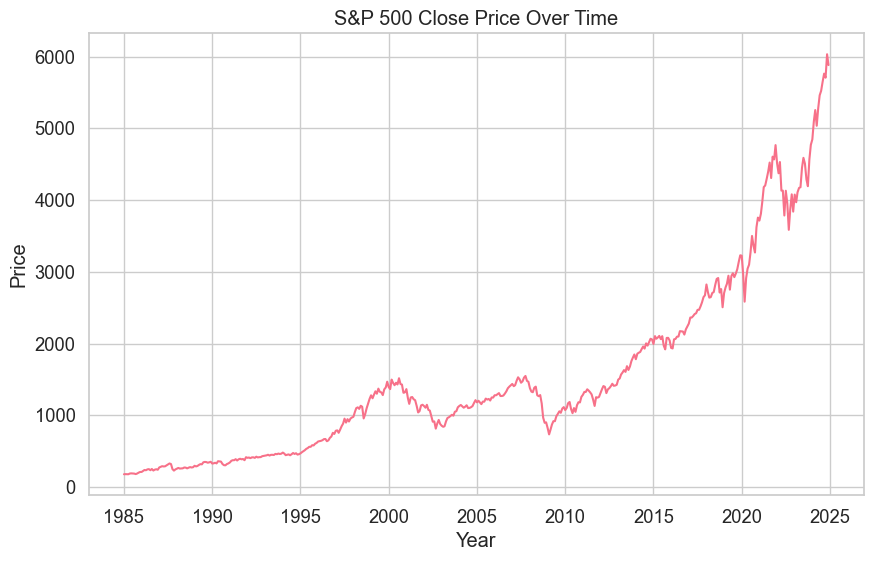

In [12]:
# plot the Close price of the S&P 500
plt.figure(figsize=(10, 6))
plt.plot(spy['Close'])
plt.title('S&P 500 Close Price Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

## SPY500 from 1885 to 2025

In [3]:

# Load the Excel file from the 'Data' sheet, skipping the header explanation rows
xls_path = "data/ie_data.csv"
df_raw = pd.read_csv(xls_path, skiprows=6)

# Manually set cleaned column names based on user's provided format
cleaned_columns = [
    "Date", "P", "D", "E", "CPI", "Fraction", "Rate_GS10", "Real_Price", "Real_Dividend", "Real_Total_Return_Price",
    "Real_Earnings", "Real_Scaled_Earnings", "CAPE", "TR_CAPE", "Excess_CAPE_Yield", "Monthly_Total_Returns",
    "Real_Total_Returns", "Annualized_Stock_Real_Return_10Y", "Annualized_Bonds_Real_Return_10Y",
    "Real_Excess_Annualized_Returns_10Y"
]

df_raw.head()
# Replace DataFrame column names
df_raw.columns = cleaned_columns[:len(df_raw.columns)]  # Adjust in case columns are fewer

# Save to CSV
csv_output_path = "data/shiller_cleaned.csv"
df_raw.to_csv(csv_output_path, index=False)

csv_output_path

'data/shiller_cleaned.csv'

In [4]:

# Load the cleaned CSV file
csv_path = "data/shiller_cleaned.csv"
df = pd.read_csv(csv_path)
# only keep the Date which end with .12
# change Date to string
df['Date'] = df['Date'].astype(str)

df = df[df['Date'].str.endswith('.12')]
# extract year from Date
df['Year'] = df['Date'].str[:4].astype(int)
# create a new column of Dividend ratio
df['Dividend_Ratio'] = df['D']/df['P']*100
# create a new column which is the annual_return of the price
df['Annual_Return'] = df['P'].pct_change()*100
# create a new column which is the Total_Return, which is the sum of the Annual_Return and Dividend_Ratio
df['Total_Return'] = df['Annual_Return'] + df['Dividend_Ratio']


In [5]:
# filter the year from 1924
df = df[df['Year'] >= 1924]
df.tail(10)

,Date,P,D,E,CPI,Fraction,Rate_GS10,Real_Price,Real_Dividend,Real_Total_Return_Price,Real_Earnings,Real_Scaled_Earnings,CAPE,TR_CAPE,Excess_CAPE_Yield,Monthly_Total_Returns,Real_Total_Returns,Annualized_Stock_Real_Return_10Y,Annualized_Bonds_Real_Return_10Y,Real_Excess_Annualized_Returns_10Y,Year,Dividend_Ratio,Annual_Return,Total_Return
1739,2015.12,2054.08,43.39,86.53,236.53,2015.96,2.24,2780.23,58.73,"1,592,931.56",117.12,"67,103.70",25.97,28.54,3.47%,1.02,50.71,NaN,NaN,NaN,2015,2.112381,-0.009249,2.103132
1751,2016.12,2246.63,45.70,94.55,241.43,2016.96,2.49,2979.04,60.60,"1,743,631.63",125.37,"73,381.18",27.87,30.59,2.91%,1.01,49.45,NaN,NaN,NaN,2016,2.034158,9.374026,11.408184
1763,2017.12,2664.34,48.93,109.88,246.52,2017.96,2.40,3459.96,63.54,"2,064,715.16",142.69,"85,150.88",32.09,35.02,2.33%,0.99,49.95,NaN,NaN,NaN,2017,1.836477,18.592737,20.429214
1775,2018.12,2567.31,53.75,132.39,251.23,2018.96,2.83,3271.46,68.49,"1,989,122.15",168.70,"102,574.24",28.29,30.82,2.50%,1.01,48.57,NaN,NaN,NaN,2018,2.093631,-3.641802,-1.548171
1787,2019.12,3176.75,58.24,139.47,256.97,2019.96,1.86,3957.62,72.56,"2,453,274.86",173.75,"107,707.03",30.33,33.21,3.19%,1.01,52.84,NaN,NaN,NaN,2019,1.833320,23.738466,25.571786
1799,2020.12,3695.31,58.28,94.13,260.47,2020.96,0.93,4541.79,71.63,"2,868,036.79",115.69,"73,057.01",33.77,37.03,3.77%,0.99,57.29,NaN,NaN,NaN,2020,1.577134,16.323601,17.900735
1811,2021.12,4674.77,60.40,197.87,278.80,2021.96,1.47,5367.91,69.35,"3,436,739.98",227.21,"145,467.55",38.30,41.72,3.28%,0.97,51.58,NaN,NaN,NaN,2021,1.292042,26.505489,27.797532
1823,2022.12,3912.38,66.92,172.75,296.80,2022.96,3.62,4220.09,72.18,"2,744,594.13",186.34,"121,186.73",28.32,30.68,2.51%,1.01,41.18,NaN,NaN,NaN,2022,1.710468,-16.308610,-14.598142
1835,2023.12,4685.05,70.30,192.43,306.75,2023.96,4.02,4889.63,73.37,"3,231,629.48",200.83,"132,733.32",31.45,33.99,1.95%,1.00,40.05,NaN,NaN,NaN,2023,1.500518,19.749360,21.249877
1847,2024.12,6010.91,74.83,210.17,315.61,2024.96,4.39,6097.29,75.91,"4,084,025.82",213.19,"142,797.00",37.71,40.54,1.26%,0.98,39.36,NaN,NaN,NaN,2024,1.244903,28.299805,29.544708


In [6]:
# save the df to csv
df.to_csv('data/spy500_history.csv', index=False)


In [11]:
# average of the Annual_Return from 1997 to 2021
df_1997_2021 = df[df['Year'] >= 1997]
df_1997_2021 = df_1997_2021[df_1997_2021['Year'] <= 2021]
df_1997_2021['Annual_Return'].mean()


9.111858130226635

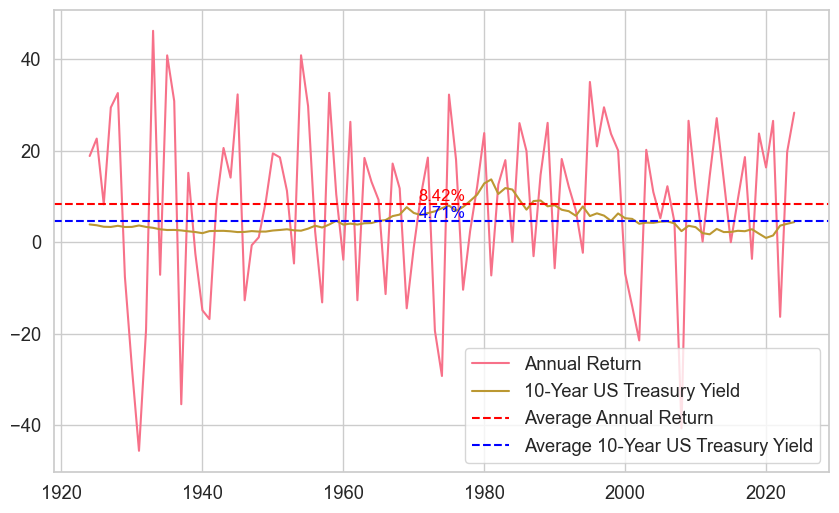

In [88]:
# plot the Dividend_Ratio and Annual_Return
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Annual_Return'], label='Annual Return')
# add Rate_GS10, which is the 10-year yield of the US Treasury
plt.plot(df['Year'], df['Rate_GS10'], label='10-Year US Treasury Yield')
# add y lines which are the average of the Annual_Return and Rate_GS10
plt.axhline(y=df['Annual_Return'].mean(), color='red', linestyle='--', label='Average Annual Return')
plt.axhline(y=df['Rate_GS10'].mean(), color='blue', linestyle='--', label='Average 10-Year US Treasury Yield')
# show the values of the average of the Annual_Return and Rate_GS10
plt.text(df['Year'].mean(), df['Annual_Return'].mean(), f'{df["Annual_Return"].mean():.2f}%', 
         ha='center', va='bottom', fontsize=12, color='red')
plt.text(df['Year'].mean(), df['Rate_GS10'].mean(), f'{df["Rate_GS10"].mean():.2f}%', 
         ha='center', va='bottom', fontsize=12, color='blue')
plt.legend()
plt.show()


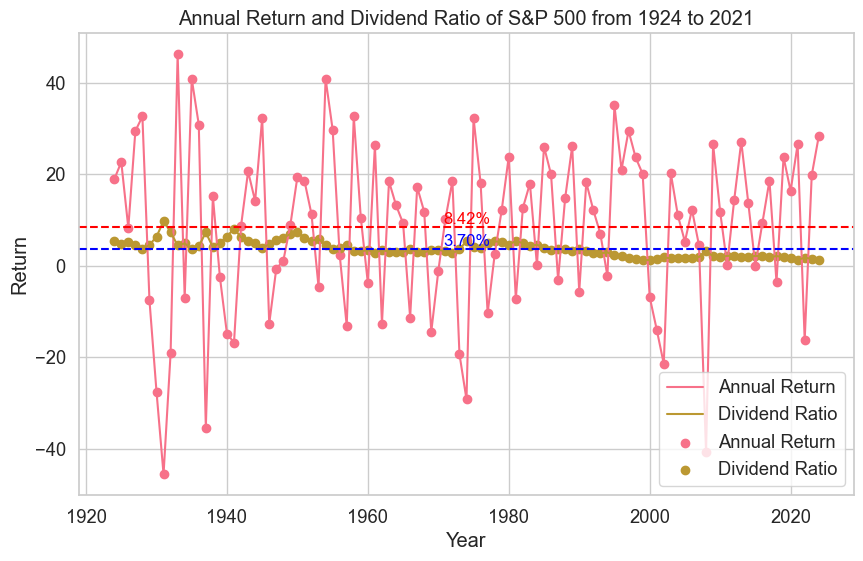

In [16]:
# plot of spy500 from 1924 , annual return, dividend ratio,
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Annual_Return', data=df, label='Annual Return')
sns.lineplot(x='Year', y='Dividend_Ratio', data=df, label='Dividend Ratio')
# show the points of each year
plt.scatter(df['Year'], df['Annual_Return'], label='Annual Return')
plt.scatter(df['Year'], df['Dividend_Ratio'], label='Dividend Ratio')
plt.legend()
plt.title('Annual Return and Dividend Ratio of S&P 500 from 1924 to 2021')
# show x line which are the average of the Annual_Return and Dividend_Ratio
plt.axhline(y=df['Annual_Return'].mean(), color='red', linestyle='--', label='Average Annual Return')
plt.axhline(y=df['Dividend_Ratio'].mean(), color='blue', linestyle='--', label='Average Dividend Ratio')
# add a text box which shows the mean of the Annual_Return and Dividend_Ratio
plt.text(df['Year'].mean(), df['Annual_Return'].mean(), f'{df["Annual_Return"].mean():.2f}%', 
         ha='center', va='bottom', fontsize=12, color='red')
plt.text(df['Year'].mean(), df['Dividend_Ratio'].mean(), f'{df["Dividend_Ratio"].mean():.2f}%', 
         ha='center', va='bottom', fontsize=12, color='blue')
plt.xlabel('Year')
plt.ylabel('Return')
plt.show()


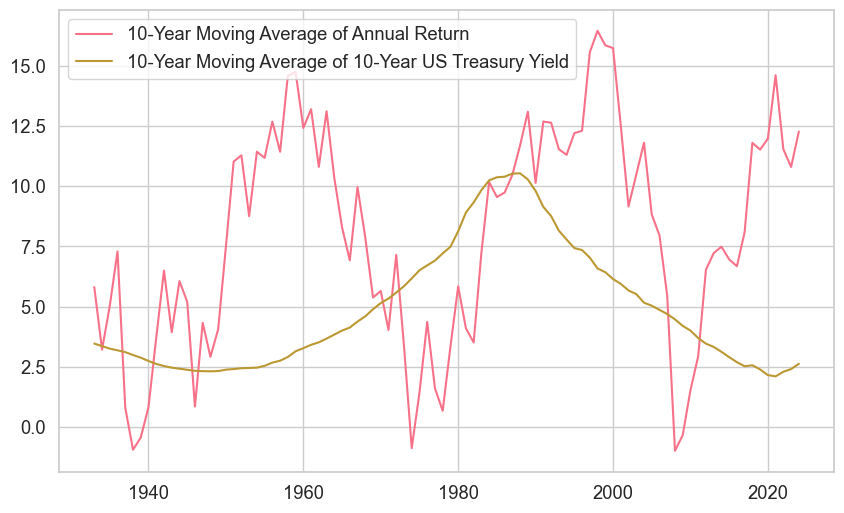

In [89]:
# make a ten year moving average of the Annual_Return and Rate_GS10, start from 1924
df['Annual_Return_MA'] = df['Annual_Return'].rolling(window=10).mean()
df['Rate_GS10_MA'] = df['Rate_GS10'].rolling(window=10).mean()


# plot the Annual_Return_MA and Rate_GS10_MA
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Annual_Return_MA'], label='10-Year Moving Average of Annual Return')
plt.plot(df['Year'], df['Rate_GS10_MA'], label='10-Year Moving Average of 10-Year US Treasury Yield')
plt.legend()
plt.show()




### Scenario 3: simulation of the 100k investment in spy500 in the year from 1924 to 2020, with 15 years waiting period, and 32 years withdrawal period, and 10% default return if no return from spy500 available


Results saved to simulation_results.csv


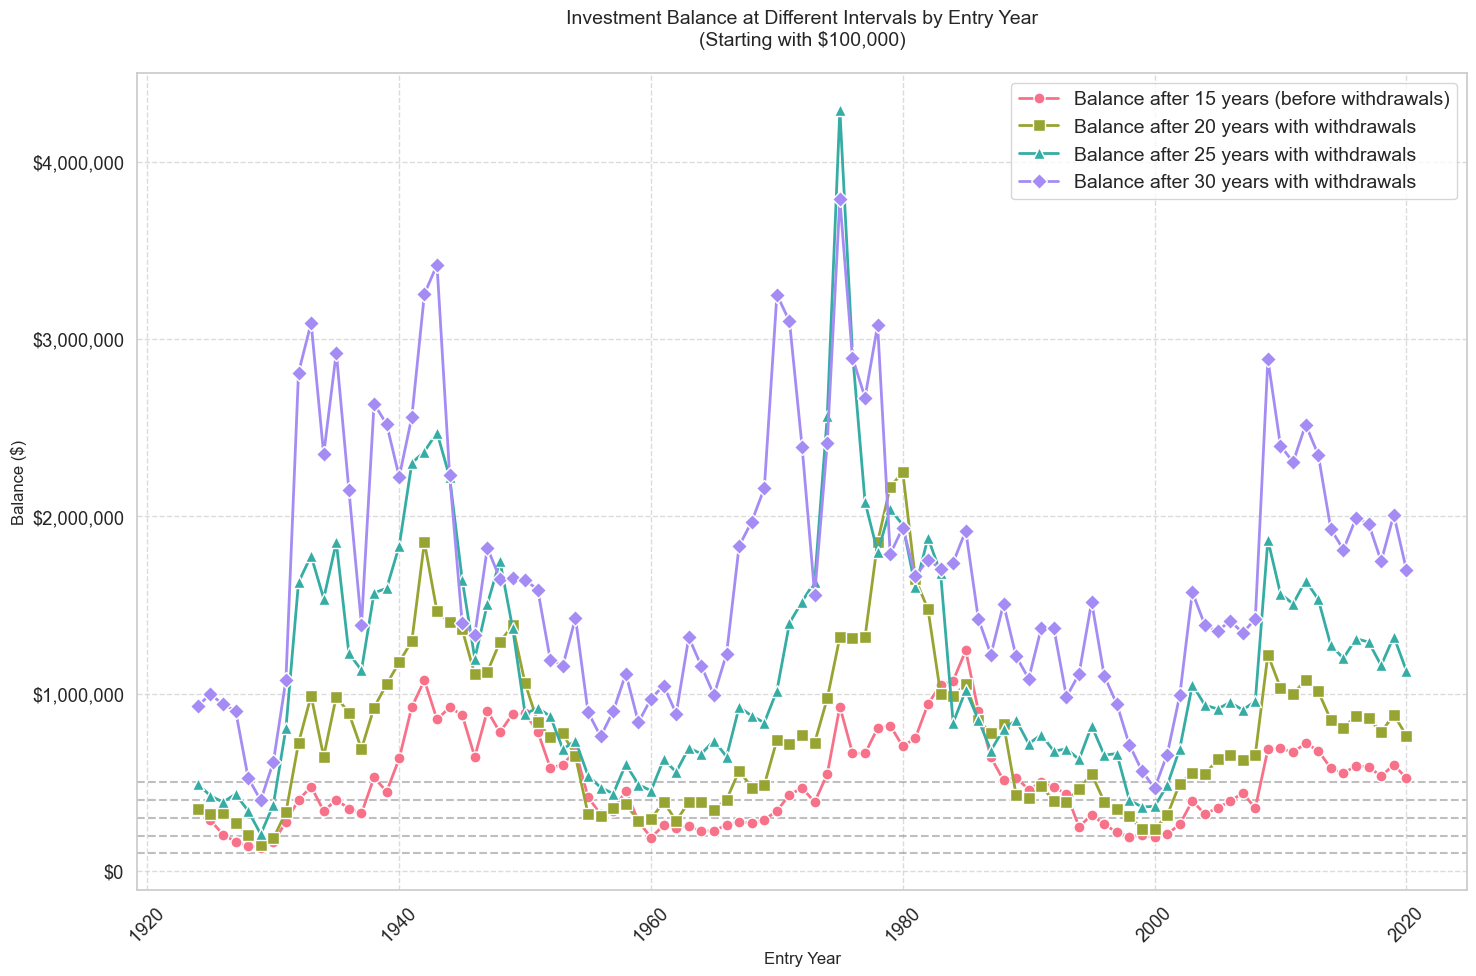


Summary Statistics:
--------------------------------------------------------------------------------

Interval: 15 years
Average Balance: $509,089.21
Minimum Balance: $131,461.03
Maximum Balance: $1,243,462.06
Best Entry Year: 1985
Worst Entry Year: 1929
Number of data points: 97

Interval: 20 years
Average Balance: $775,783.20
Minimum Balance: $145,112.13
Maximum Balance: $2,248,026.76
Best Entry Year: 1980
Worst Entry Year: 1929
Number of data points: 97

Interval: 25 years
Average Balance: $1,153,823.15
Minimum Balance: $207,793.84
Maximum Balance: $4,290,201.66
Best Entry Year: 1975
Worst Entry Year: 1929
Number of data points: 97

Interval: 30 years
Average Balance: $1,678,499.87
Minimum Balance: $398,468.77
Maximum Balance: $3,787,468.70
Best Entry Year: 1975
Worst Entry Year: 1929
Number of data points: 97


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict, Optional

# Configuration
@dataclass
class SimulationConfig:
    base_balance: float = 100000
    default_return: float = 0.10
    waiting_years: int = 15  # Years before withdrawals start
    withdrawal_schedule: List[float] = None
    
    def __post_init__(self):
        if self.withdrawal_schedule is None:
            self.withdrawal_schedule = [
                12282, 13024, 13284, 14087, 14368, 15236, 15541, 16479, 16809, 17824,
                18181, 19278, 19664, 20852, 21269, 22562, 23013, 24412, 24900, 26414,
                26943, 28581, 29152, 30925, 31543, 33461, 34130, 36206, 36930, 39175,
                39959, 42388
            ]

class HistoricalReturns:
    def __init__(self, data_path: str = 'data/spy500_history.csv'):
        self.df = pd.read_csv(data_path)
        self.df['Annual_Return'] = self.df['Total_Return'] / 100  # Convert to decimal
        
    def get_return(self, year: int, default_return: float) -> float:
        """Get the return for a specific year, using default if not available"""
        year_data = self.df[self.df['Year'] == year]
        if not year_data.empty and not pd.isna(year_data['Annual_Return'].iloc[0]):
            return year_data['Annual_Return'].iloc[0]
        return default_return

@dataclass
class SimulationResult:
    entry_year: int
    balances: List[float]
    withdrawals: List[float]
    cumulative_withdrawals: List[float]
    returns: List[float]
    
    def has_zero_balance(self) -> bool:
        return any(balance <= 0 for balance in self.balances)

class RetirementSimulator:
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.historical_returns = HistoricalReturns()
        
    def simulate_single_path(self, entry_year: int) -> SimulationResult:
        """Run simulation for a single entry year"""
        total_years = self.config.waiting_years + len(self.config.withdrawal_schedule)
        returns = []
        balances = [self.config.base_balance]
        withdrawals = [0]
        cumulative_withdrawals = [0]
        current_balance = self.config.base_balance
        
        # Calculate returns for each year
        for year_offset in range(total_years):
            target_year = entry_year + year_offset
            annual_return = self.historical_returns.get_return(
                target_year, self.config.default_return)
            returns.append(annual_return)
            
            # Apply return (round to 2 decimal places to avoid floating point issues)
            if current_balance > 0:
                current_balance = round(current_balance * (1 + annual_return), 2)
            
            # Apply withdrawal if after waiting period
            if year_offset >= self.config.waiting_years:
                withdrawal_idx = year_offset - self.config.waiting_years
                if withdrawal_idx < len(self.config.withdrawal_schedule):
                    withdrawal = self.config.withdrawal_schedule[withdrawal_idx]
                    # If withdrawal would exceed balance, set balance to zero
                    if withdrawal >= current_balance:
                        withdrawal = current_balance
                        current_balance = 0
                    else:
                        current_balance = round(current_balance - withdrawal, 2)
                    withdrawals.append(withdrawal)
                    cumulative_withdrawals.append(round(cumulative_withdrawals[-1] + withdrawal, 2))
                else:
                    withdrawals.append(0)
                    cumulative_withdrawals.append(cumulative_withdrawals[-1])
            else:
                withdrawals.append(0)
                cumulative_withdrawals.append(cumulative_withdrawals[-1])
            
            balances.append(current_balance)
        
        return SimulationResult(
            entry_year=entry_year,
            balances=balances,
            withdrawals=withdrawals,
            cumulative_withdrawals=cumulative_withdrawals,
            returns=returns
        )

class SimulationAnalyzer:
    def __init__(self, results: List[SimulationResult], intervals: List[int]):
        self.results = results
        self.intervals = intervals
        
    def create_summary_dataframe(self) -> pd.DataFrame:
        """Create a DataFrame with summary statistics for each entry year"""
        data = []
        for result in self.results:
            row = {'Entry_Year': result.entry_year}
            for interval in self.intervals:
                if interval < len(result.balances):
                    row[f'Balance_After_{interval}_Years'] = result.balances[interval]
            row['Has_Zero_Balance'] = result.has_zero_balance()
            data.append(row)
        return pd.DataFrame(data)
    
    def plot_results(self):
        """Create visualization of simulation results"""
        plt.figure(figsize=(15, 10))
        
        # Add reference lines
        for balance in [100000, 200000, 300000, 400000, 500000]:
            plt.axhline(y=balance, color='gray', linestyle='--', alpha=0.5)
        
        # Plot balance at each interval
        markers = ['o', 's', '^', 'D']
        colors = sns.color_palette("husl", len(self.intervals))
        
        for interval, marker, color in zip(self.intervals, markers, colors):
            data = [(r.entry_year, r.balances[interval]) 
                   for r in self.results 
                   if interval < len(r.balances)]
            
            if data:
                years, balances = zip(*data)
                label = (f'Balance after {interval} years '
                        f'{"(before withdrawals)" if interval <= 15 else "with withdrawals"}')
                plt.plot(years, balances, label=label, marker=marker, markersize=8,
                        linewidth=2, color=color, markeredgecolor='white', markeredgewidth=1)
        
        plt.title('Investment Balance at Different Intervals by Entry Year\n(Starting with $100,000)',
                 pad=20, fontsize=14)
        plt.xlabel('Entry Year', fontsize=12)
        plt.ylabel('Balance ($)', fontsize=12)
        plt.legend(
            #bbox_to_anchor=(1.05, 1), loc='upper left', 
            fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def main():
    # Initialize configuration
    config = SimulationConfig()
    simulator = RetirementSimulator(config)
    
    # Run simulations
    results = []
    for entry_year in range(1924, 2021):
        result = simulator.simulate_single_path(entry_year)
        results.append(result)
    
    # Analyze results
    intervals = [15, 20, 25, 30]
    analyzer = SimulationAnalyzer(results, intervals)
    
    # Generate and save summary
    df_results = analyzer.create_summary_dataframe()
    df_results.to_csv('simulation_results.csv', index=False)
    print(f"\nResults saved to simulation_results.csv")
    
    # Print summary of zero balances
    zero_balance_results = [r for r in results if r.has_zero_balance()]
    if zero_balance_results:
        print(f"\nFound {len(zero_balance_results)} entry years with non-positive balances")
        print("\nEntry years with non-positive balances:")
        for result in zero_balance_results:
            print(f"Entry Year: {result.entry_year}")
            for interval in intervals:
                if interval < len(result.balances) and result.balances[interval] <= 0:
                    print(f"  After {interval} years: ${result.balances[interval]:,.2f}")
    
    # Create visualization
    analyzer.plot_results()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 80)
    for interval in intervals:
        balances = [r.balances[interval] for r in results if interval < len(r.balances)]
        if balances:
            print(f"\nInterval: {interval} years")
            print(f"Average Balance: ${np.mean(balances):,.2f}")
            print(f"Minimum Balance: ${min(balances):,.2f}")
            print(f"Maximum Balance: ${max(balances):,.2f}")
            best_result = max(results, key=lambda r: r.balances[interval] if interval < len(r.balances) else -float('inf'))
            worst_result = min(results, key=lambda r: r.balances[interval] if interval < len(r.balances) else float('inf'))
            print(f"Best Entry Year: {best_result.entry_year}")
            print(f"Worst Entry Year: {worst_result.entry_year}")
            print(f"Number of data points: {len(balances)}")

if __name__ == "__main__":
    main() 

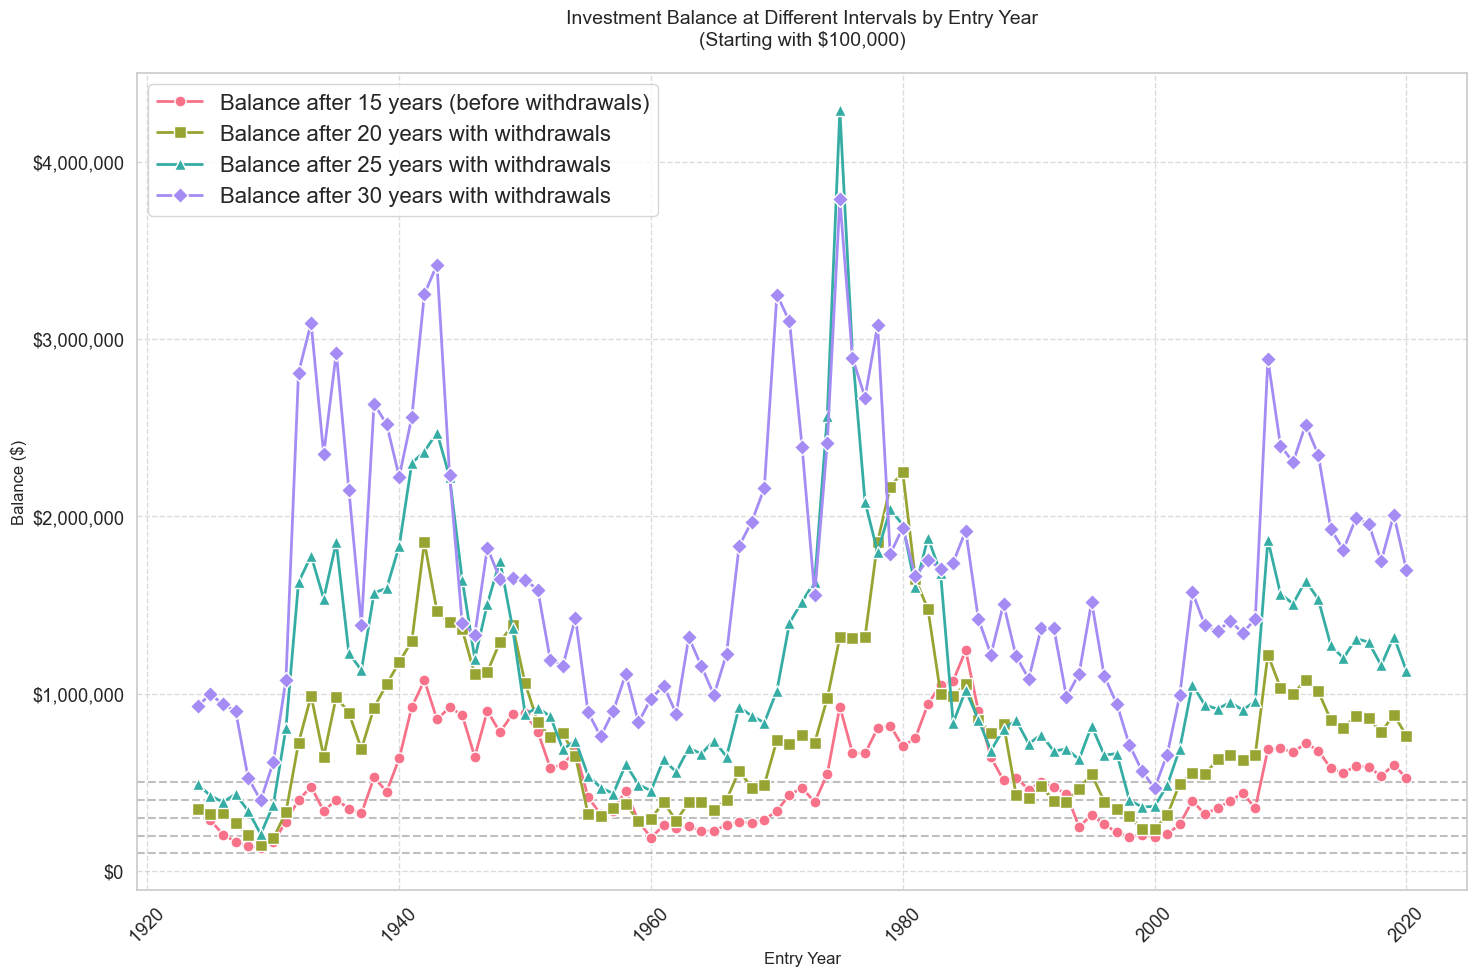


Summary Statistics:
--------------------------------------------------------------------------------

Interval: 15 years
Average Balance: $509,089.21
Minimum Balance: $131,461.03
Maximum Balance: $1,243,462.11
Best Entry Year: 1985
Worst Entry Year: 1929
Number of data points: 97

Interval: 20 years
Average Balance: $775,783.21
Minimum Balance: $145,112.14
Maximum Balance: $2,248,026.64
Best Entry Year: 1980
Worst Entry Year: 1929
Number of data points: 97

Interval: 25 years
Average Balance: $1,153,823.15
Minimum Balance: $207,793.85
Maximum Balance: $4,290,201.62
Best Entry Year: 1975
Worst Entry Year: 1929
Number of data points: 97

Interval: 30 years
Average Balance: $1,678,499.86
Minimum Balance: $398,468.80
Maximum Balance: $3,787,468.67
Best Entry Year: 1975
Worst Entry Year: 1929
Number of data points: 97


In [91]:
# Create the plot
plt.figure(figsize=(15, 10))

# Add horizontal balance reference lines
balance_levels = [100000, 200000, 300000, 400000, 500000]
for balance in balance_levels:
    plt.axhline(y=balance, color='gray', linestyle='--', alpha=0.5)

# Plot balance at each interval
markers = ['o', 's', '^', 'D']
colors = sns.color_palette("husl", len(intervals))

for interval, marker, color in zip(intervals, markers, colors):
    valid_data = [(year, bal) for year, bal in zip(entry_years, balance_at_intervals[interval]) if bal is not None]
    if valid_data:
        years, balances = zip(*valid_data)
        if interval == 15:
            label = f'Balance after {interval} years (before withdrawals)'
        else:
            label = f'Balance after {interval} years with withdrawals'
        plt.plot(years, balances, label=label, marker=marker, markersize=8, 
                linewidth=2, color=color, markeredgecolor='white', markeredgewidth=1)

plt.title('Investment Balance at Different Intervals by Entry Year\n(Starting with $100,000)', pad=20, fontsize=14)
plt.xlabel('Entry Year', fontsize=12)
plt.ylabel('Balance ($)', fontsize=12)
plt.legend( loc='upper left', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("-" * 80)
for interval in intervals:
    valid_balances = [b for b in balance_at_intervals[interval] if b is not None]
    if valid_balances:
        print(f"\nInterval: {interval} years")
        print(f"Average Balance: ${np.mean(valid_balances):,.2f}")
        print(f"Minimum Balance: ${min(valid_balances):,.2f}")
        print(f"Maximum Balance: ${max(valid_balances):,.2f}")
        best_year_idx = balance_at_intervals[interval].index(max(valid_balances))
        worst_year_idx = balance_at_intervals[interval].index(min(valid_balances))
        print(f"Best Entry Year: {entry_years[best_year_idx]}")
        print(f"Worst Entry Year: {entry_years[worst_year_idx]}")
        print(f"Number of data points: {len(valid_balances)}") 